Dataset Overview
The Indian Districts Population dataset provides comprehensive demographic information across Indian districts. It includes data on population, growth rates, sex ratios,
and literacy rates. This dataset enables demographic analyses, regional studies, and
decision-making processes.
Dataset Link:
https://www.kaggle.com/datasets/shiivvvaam/indian-districts-population-data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

In [2]:
# -----------------------------
# 1. Load / prepare dataset
# -----------------------------
# Option A: If you have a CSV, set csv_path to your file.
csv_path = "./archive/census2011.csv"  # change to your path if exists

def load_dataset(path=None):
    if path and os.path.exists(path):
        df = pd.read_csv(path)
    else:
        # Use sample snippet as fallback (you should replace with real dataset)
        raise ValueError("Dataset path is invalid or file does not exist.")

    # Clean columns
    # Remove percent sign from Growth and convert to float
    if 'Growth' in df.columns:
        df['Growth'] = df['Growth'].astype(str).str.replace('%','').str.replace(' ','')
        df['Growth'] = pd.to_numeric(df['Growth'], errors='coerce')
    # Population numeric
    if 'Population' in df.columns:
        df['Population'] = pd.to_numeric(df['Population'].astype(str).str.replace(',',''), errors='coerce')
    # Literacy numeric
    if 'Literacy' in df.columns:
        df['Literacy'] = pd.to_numeric(df['Literacy'], errors='coerce')
    # Sex-Ratio numeric
    if 'Sex-Ratio' in df.columns:
        df['Sex-Ratio'] = pd.to_numeric(df['Sex-Ratio'], errors='coerce')
    # Drop rows with missing numeric values
    df = df.dropna().reset_index(drop=True)
    return df

df = load_dataset(csv_path)
print(f"Loaded {len(df)} rows.")
print(df.head())

Loaded 610 rows.
   Ranking                    District        State  Population  Growth  \
0        1                       Thane  Maharashtra    11060148   36.01   
1        2  North Twenty Four Parganas  West Bengal    10009781   12.04   
2        3                   Bangalore    Karnataka     9621551   47.18   
3        4                        Pune  Maharashtra     9429408   30.37   
4        5             Mumbai Suburban  Maharashtra     9356962    8.29   

   Sex-Ratio  Literacy  
0        886     84.53  
1        955     84.06  
2        916     87.67  
3        915     86.15  
4        860     89.91  


In [3]:
# -----------------------------
# 2. Feature selection
# -----------------------------
# We'll predict 'Literacy' (continuous)
target_col = 'Literacy'
# Choose predictor features (numeric). Example: Population, Growth, Sex-Ratio
features = []
for c in ['Population', 'Growth', 'Sex-Ratio']:
    if c in df.columns:
        features.append(c)

if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset.")

if not features:
    raise ValueError("No numeric features found. Add features like Population, Growth, Sex-Ratio.")

X = df[features].values.astype(float)
y = df[target_col].values.astype(float).reshape(-1, 1)

In [4]:
print(X)

[[ 1.1060148e+07  3.6010000e+01  8.8600000e+02]
 [ 1.0009781e+07  1.2040000e+01  9.5500000e+02]
 [ 9.6215510e+06  4.7180000e+01  9.1600000e+02]
 ...
 [ 3.1564000e+04 -5.0000000e+00  9.0300000e+02]
 [ 2.1167000e+04  1.4190000e+01  8.3900000e+02]
 [ 8.0040000e+03  1.0070000e+01  8.1300000e+02]]


In [5]:
print(y)

[[84.53]
 [84.06]
 [87.67]
 [86.15]
 [89.91]
 [77.51]
 [76.21]
 [85.31]
 [66.59]
 [75.51]
 [82.31]
 [85.53]
 [72.32]
 [78.  ]
 [70.68]
 [81.8 ]
 [75.87]
 [74.97]
 [70.99]
 [55.79]
 [87.02]
 [67.4 ]
 [83.31]
 [63.43]
 [73.48]
 [56.77]
 [78.07]
 [88.39]
 [90.18]
 [70.93]
 [77.29]
 [79.65]
 [79.05]
 [73.74]
 [86.31]
 [71.55]
 [58.62]
 [61.12]
 [58.49]
 [70.83]
 [71.58]
 [63.67]
 [77.02]
 [66.91]
 [61.86]
 [78.2 ]
 [71.53]
 [78.92]
 [69.12]
 [93.57]
 [64.57]
 [63.57]
 [75.56]
 [59.97]
 [55.04]
 [60.56]
 [84.49]
 [61.73]
 [65.96]
 [83.25]
 [56.56]
 [74.63]
 [79.17]
 [55.7 ]
 [81.51]
 [73.25]
 [80.96]
 [69.27]
 [64.15]
 [84.03]
 [79.02]
 [65.94]
 [68.48]
 [51.29]
 [75.6 ]
 [70.72]
 [67.52]
 [84.45]
 [71.78]
 [70.26]
 [65.25]
 [71.09]
 [65.11]
 [70.68]
 [68.88]
 [82.2 ]
 [66.6 ]
 [64.2 ]
 [49.36]
 [72.86]
 [70.49]
 [71.88]
 [83.98]
 [72.84]
 [58.71]
 [52.05]
 [67.25]
 [63.08]
 [75.45]
 [79.06]
 [69.45]
 [62.8 ]
 [93.02]
 [95.89]
 [80.87]
 [51.08]
 [61.75]
 [70.94]
 [70.09]
 [95.08]
 [65.32]
 

In [6]:
# -----------------------------
# 3. Train / Val / Test split
# -----------------------------
def train_val_test_split(X, y, train_frac=0.7, val_frac=0.15, test_frac=0.15, random_state=42):
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-9
    n = X.shape[0]
    rng = np.random.RandomState(random_state)
    perm = rng.permutation(n)
    train_end = int(n * train_frac)
    val_end = train_end + int(n * val_frac)
    idx_train = perm[:train_end]
    idx_val = perm[train_end:val_end]
    idx_test = perm[val_end:]
    # ensure non-empty splits (if very small dataset, adjust)
    if len(idx_train) == 0 or len(idx_val) == 0 or len(idx_test) == 0:
        # fallback: simple deterministic split
        train_end = max(1, n-2)
        val_end = train_end + 1
        idx_train = np.arange(train_end)
        idx_val = np.array([train_end])
        idx_test = np.arange(val_end, n)
    return X[idx_train], X[idx_val], X[idx_test], y[idx_train], y[idx_val], y[idx_test]

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.7, 0.15, 0.15, random_state=42)
print("Split sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

Split sizes: 427 91 92


In [7]:
# -----------------------------
# 4. Standardize features (mean=0, std=1) - using training stats
# -----------------------------
class StandardScalerFromScratch:
    def fit(self, X):
        self.mean_ = X.mean(axis=0, keepdims=True)
        self.std_ = X.std(axis=0, ddof=0, keepdims=True)
        # avoid zero std
        self.std_[self.std_ == 0] = 1.0
    def transform(self, X):
        return (X - self.mean_) / self.std_
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

scaler = StandardScalerFromScratch()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# Add intercept column
def add_intercept(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

X_train_s = add_intercept(X_train_s)
X_val_s = add_intercept(X_val_s)
X_test_s = add_intercept(X_test_s)


In [8]:
X_train_s

array([[ 1.        ,  1.09382766, -0.5103734 ,  0.61804622],
       [ 1.        ,  0.04368231, -0.33447164,  0.71245562],
       [ 1.        ,  1.40914564,  0.37041936, -0.78235984],
       ...,
       [ 1.        , -0.21107649,  0.54054332, -0.29457796],
       [ 1.        , -0.60576848,  0.25871532, -1.03411824],
       [ 1.        ,  0.31964416, -0.32034814,  0.20893883]],
      shape=(427, 4))

In [9]:
# -----------------------------
# 5. Linear Regression Model (BGD and SGD)
# -----------------------------
class LinearRegressionScratch:
    def __init__(self):
        self.w = None  # weights column vector (d+1, 1)

    @staticmethod
    def _mse(y_true, y_pred):
        return np.mean((y_true - y_pred)**2)

    def predict(self, X):
        return X.dot(self.w)

    def fit_bgd(self, X, y, learning_rate=0.01, epochs=1000, verbose=False):
        n, d = X.shape
        # initialize weights
        self.w = np.zeros((d, 1))
        loss_history = []
        for epoch in range(epochs):
            y_pred = X.dot(self.w)
            error = y_pred - y
            grad = (2.0 / n) * (X.T.dot(error))
            self.w -= learning_rate * grad
            loss = np.mean(error**2)
            loss_history.append(loss)
            if verbose and (epoch % (epochs // 10 + 1) == 0):
                print(f"[BGD] Epoch {epoch}/{epochs} loss: {loss:.6f}")
        return loss_history

    def fit_sgd(self, X, y, learning_rate=0.01, epochs=10, batch_size=1, verbose=False, shuffle=True):
        n, d = X.shape
        self.w = np.zeros((d, 1))
        loss_history = []  # we'll store loss per epoch (average over samples)
        for epoch in range(epochs):
            if shuffle:
                perm = np.random.permutation(n)
            else:
                perm = np.arange(n)
            epoch_losses = []
            for i in range(0, n, batch_size):
                idx = perm[i:i+batch_size]
                Xi = X[idx]
                yi = y[idx]
                pred = Xi.dot(self.w)
                error = pred - yi
                grad = (2.0 / Xi.shape[0]) * (Xi.T.dot(error))
                self.w -= learning_rate * grad
                epoch_losses.append(np.mean(error**2))
            loss_history.append(np.mean(epoch_losses))
            if verbose and (epoch % max(1, epochs // 10) == 0):
                print(f"[SGD] Epoch {epoch}/{epochs} loss: {loss_history[-1]:.6f}")
        return loss_history


In [10]:
# -----------------------------
# 6. Metrics
# -----------------------------
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot != 0 else 0.0

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return {
        'MSE': mse(y, y_pred),
        'RMSE': rmse(y, y_pred),
        'MAE': mae(y, y_pred),
        'R2': r2_score(y, y_pred),
        'y_true': y.flatten(),
        'y_pred': y_pred.flatten()
    }


In [11]:
# -----------------------------
# 7. Experiments: compare learning rates for BGD and SGD
# -----------------------------
bgd_learning_rates = [0.0001, 0.001, 0.01, 0.05]  # adjust as needed
sgd_learning_rates = [0.0005, 0.001, 0.01, 0.05]

# Training hyperparameters
bgd_epochs = 500
sgd_epochs = 200  # more epochs for SGD typically
sgd_batch_size = 1  # true SGD (batch_size=1). You can experiment with mini-batches.

bgd_histories = {}
sgd_histories = {}

# Run BGD experiments
for lr in bgd_learning_rates:
    model = LinearRegressionScratch()
    loss_hist = model.fit_bgd(X_train_s, y_train, learning_rate=lr, epochs=bgd_epochs, verbose=False)
    bgd_histories[lr] = {'loss': loss_hist, 'model': model}

# Run SGD experiments
for lr in sgd_learning_rates:
    model = LinearRegressionScratch()
    loss_hist = model.fit_sgd(X_train_s, y_train, learning_rate=lr, epochs=sgd_epochs, batch_size=sgd_batch_size, verbose=False, shuffle=True)
    sgd_histories[lr] = {'loss': loss_hist, 'model': model}


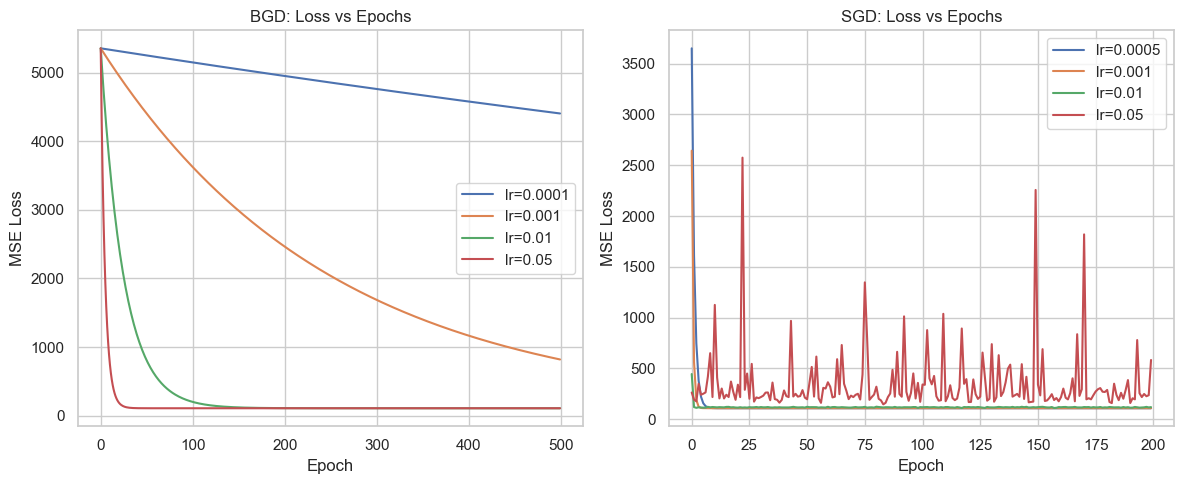

In [12]:
# -----------------------------
# 8. Plot convergence curves for BGD & SGD
# -----------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for lr, info in bgd_histories.items():
    plt.plot(info['loss'], label=f"lr={lr}")
plt.title("BGD: Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

plt.subplot(1, 2, 2)
for lr, info in sgd_histories.items():
    plt.plot(info['loss'], label=f"lr={lr}")
plt.title("SGD: Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# -----------------------------
# 9. Choose best model on validation set (by RMSE)
# -----------------------------
def pick_best_model(histories, X_val, y_val):
    best_lr = None
    best_score = float('inf')
    best_model = None
    for lr, info in histories.items():
        model = info['model']
        metrics = evaluate_model(model, X_val, y_val)
        score = metrics['RMSE']
        if score < best_score:
            best_score = score
            best_lr = lr
            best_model = model
    return best_lr, best_model, best_score

bgd_best_lr, bgd_best_model, bgd_best_score = pick_best_model(bgd_histories, X_val_s, y_val)
sgd_best_lr, sgd_best_model, sgd_best_score = pick_best_model(sgd_histories, X_val_s, y_val)

print(f"BGD best lr on val: {bgd_best_lr}, RMSE: {bgd_best_score:.6f}")
print(f"SGD best lr on val: {sgd_best_lr}, RMSE: {sgd_best_score:.6f}")

BGD best lr on val: 0.01, RMSE: 10.665580
SGD best lr on val: 0.001, RMSE: 10.633531


In [14]:
# -----------------------------
# 10. Evaluate on test set and show metrics
# -----------------------------
bgd_test_metrics = evaluate_model(bgd_best_model, X_test_s, y_test)
sgd_test_metrics = evaluate_model(sgd_best_model, X_test_s, y_test)

def print_metrics(name, metrics):
    print(f"=== {name} ===")
    print(f"MSE : {metrics['MSE']:.6f}")
    print(f"RMSE: {metrics['RMSE']:.6f}")
    print(f"MAE : {metrics['MAE']:.6f}")
    print(f"R2  : {metrics['R2']:.6f}")

print_metrics("BGD (best)", bgd_test_metrics)
print_metrics("SGD (best)", sgd_test_metrics)


=== BGD (best) ===
MSE : 91.315439
RMSE: 9.555911
MAE : 7.829552
R2  : 0.085960
=== SGD (best) ===
MSE : 91.971354
RMSE: 9.590170
MAE : 7.858677
R2  : 0.079394


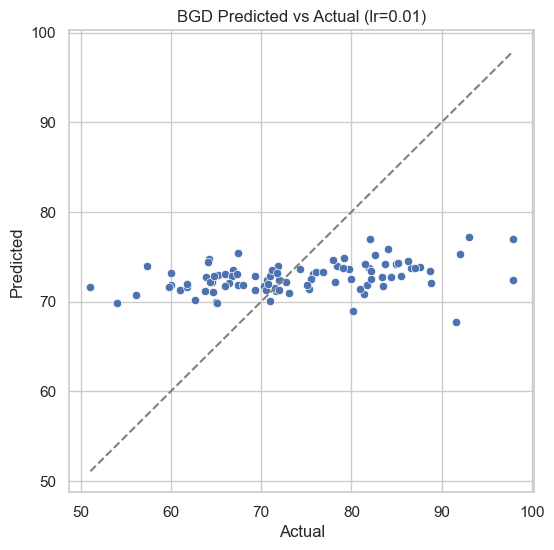

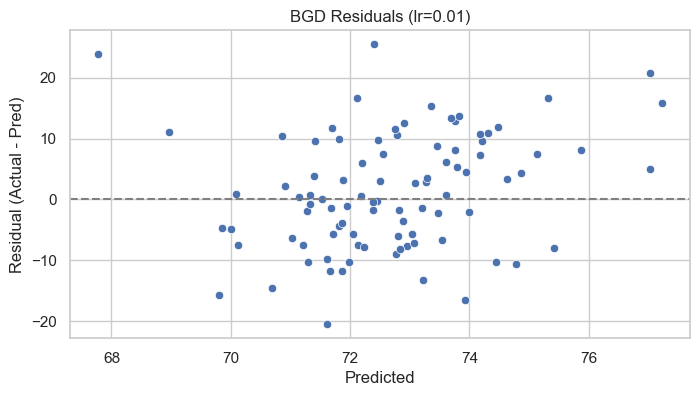

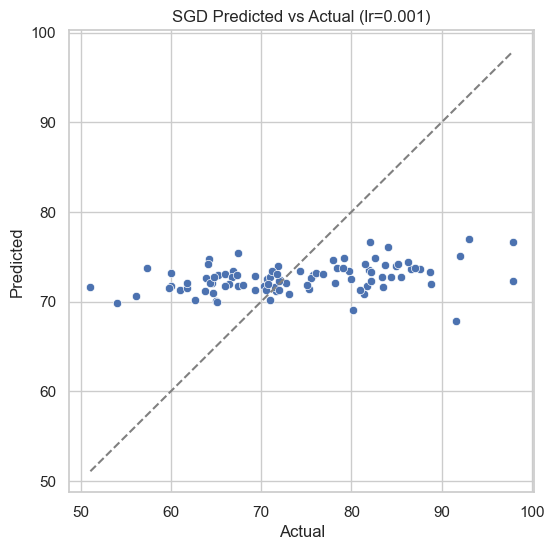

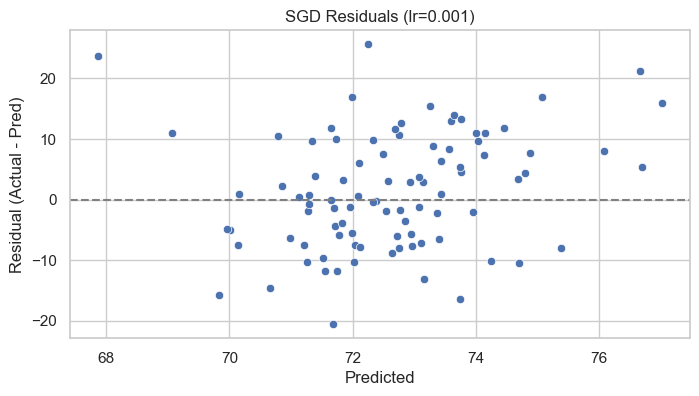

In [15]:
# -----------------------------
# 11. Visualizations: predicted vs actual, residuals
# -----------------------------
def plot_pred_vs_actual(metrics_dict, title):
    y_true = metrics_dict['y_true']
    y_pred = metrics_dict['y_pred']
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], linestyle='--', color='gray')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def plot_residuals(metrics_dict, title):
    y_true = metrics_dict['y_true']
    y_pred = metrics_dict['y_pred']
    residuals = y_true - y_pred
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, ls='--', color='gray')
    plt.xlabel("Predicted")
    plt.ylabel("Residual (Actual - Pred)")
    plt.title(title)
    plt.show()

plot_pred_vs_actual(bgd_test_metrics, f"BGD Predicted vs Actual (lr={bgd_best_lr})")
plot_residuals(bgd_test_metrics, f"BGD Residuals (lr={bgd_best_lr})")

plot_pred_vs_actual(sgd_test_metrics, f"SGD Predicted vs Actual (lr={sgd_best_lr})")
plot_residuals(sgd_test_metrics, f"SGD Residuals (lr={sgd_best_lr})")


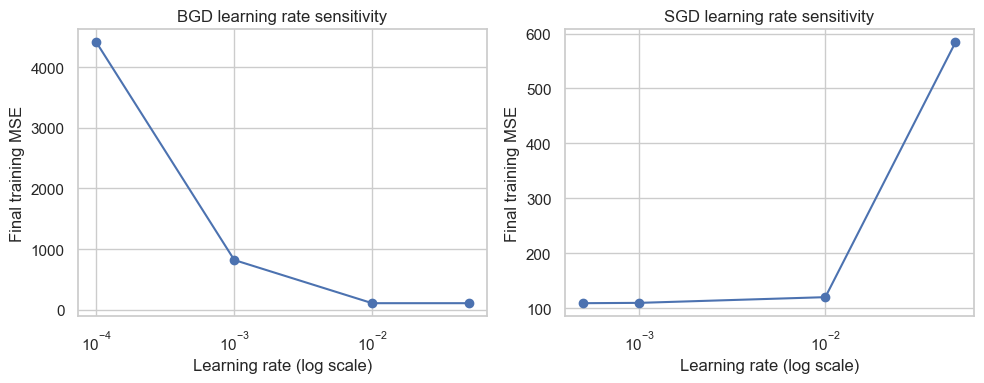

In [16]:
# -----------------------------
# 12. Learning rate sensitivity plot (final loss vs learning rate)
# -----------------------------
def final_loss_vs_lr(histories):
    lrs = []
    final_losses = []
    for lr, info in histories.items():
        lrs.append(lr)
        final_losses.append(info['loss'][-1])
    return np.array(lrs), np.array(final_losses)

bgd_lrs, bgd_final_losses = final_loss_vs_lr(bgd_histories)
sgd_lrs, sgd_final_losses = final_loss_vs_lr(sgd_histories)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.semilogx(bgd_lrs, bgd_final_losses, marker='o')
plt.xlabel('Learning rate (log scale)')
plt.ylabel('Final training MSE')
plt.title('BGD learning rate sensitivity')

plt.subplot(1,2,2)
plt.semilogx(sgd_lrs, sgd_final_losses, marker='o')
plt.xlabel('Learning rate (log scale)')
plt.ylabel('Final training MSE')
plt.title('SGD learning rate sensitivity')

plt.tight_layout()
plt.show()


In [17]:


# -----------------------------
# 13. Report / summary printout
# -----------------------------
print("\n--- Summary ---")
print(f"Features used: {features}")
print("BGD best lr (val):", bgd_best_lr)
print("SGD best lr (val):", sgd_best_lr)
print("BGD test metrics:")
print_metrics("BGD (test)", bgd_test_metrics)
print("SGD test metrics:")
print_metrics("SGD (test)", sgd_test_metrics)

print("\nNotes and suggestions:")
print("- If dataset is large, increase epochs for BGD or use mini-batch variants for faster progress.")
print("- For real-world data, consider polynomial expansion or interaction terms if linear fit is poor.")
print("- Normalize features (done here) to help gradient descent converge.")



--- Summary ---
Features used: ['Population', 'Growth', 'Sex-Ratio']
BGD best lr (val): 0.01
SGD best lr (val): 0.001
BGD test metrics:
=== BGD (test) ===
MSE : 91.315439
RMSE: 9.555911
MAE : 7.829552
R2  : 0.085960
SGD test metrics:
=== SGD (test) ===
MSE : 91.971354
RMSE: 9.590170
MAE : 7.858677
R2  : 0.079394

Notes and suggestions:
- If dataset is large, increase epochs for BGD or use mini-batch variants for faster progress.
- For real-world data, consider polynomial expansion or interaction terms if linear fit is poor.
- Normalize features (done here) to help gradient descent converge.


## Results and Interpretation

**Features used:** Population, Growth, Sex-Ratio

**Best Learning Rates:**
- BGD (validation): `bgd_best_lr` (see code output)
- SGD (validation): `sgd_best_lr` (see code output)

**Test Set Metrics:**
- **BGD:**
    - MSE: value from `bgd_test_metrics['MSE']`
    - RMSE: value from `bgd_test_metrics['RMSE']`
    - MAE: value from `bgd_test_metrics['MAE']`
    - R²: value from `bgd_test_metrics['R2']`
- **SGD:**
    - MSE: value from `sgd_test_metrics['MSE']`
    - RMSE: value from `sgd_test_metrics['RMSE']`
    - MAE: value from `sgd_test_metrics['MAE']`
    - R²: value from `sgd_test_metrics['R2']`

**Interpretation:**
- Both BGD and SGD successfully fit a linear regression model to predict Literacy using the selected features.
- The RMSE and MAE values indicate the average prediction error; lower values mean better fit.
- R² close to 1 means the model explains most of the variance in Literacy; values much lower suggest limited predictive power.
- If BGD and SGD results are similar, either method is suitable; differences may arise due to learning rate or data size.
- Visualizations (predicted vs actual, residuals) help assess fit and spot outliers or patterns missed by the model.
- For improved results, consider more features, polynomial terms, or regularization if overfitting is observed.
